In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM
from keras.layers import GRU
import tensorflow as tf
import math
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [36]:
dataset = pd.read_csv('goog1.csv', index_col='Date', parse_dates=['Date']) 
dataset.tail()

,Close,High,Low,Open,Adj Close,Volume
Date,,,,,,
2019-04-26,1272.180054,1273.069946,1260.319946,1269.000000,1272.180054,1241400
2019-04-29,1287.579956,1289.270020,1266.295044,1274.000000,1287.579956,2499400
2019-04-30,1188.479980,1192.810059,1175.000000,1185.000000,1188.479980,6207000
2019-05-01,1168.079956,1188.050049,1167.180054,1188.050049,1168.079956,2639200
2019-05-02,1162.609985,1174.189941,1155.001953,1167.760010,1162.609985,1943700


In [37]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = pd.stats.moments.rolling_std(dataset['Close'],20)
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
 
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['Close']-1
    
    return dataset
    

In [38]:
dataset_TI = get_technical_indicators(dataset[['Close']])

/Users/san/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/san/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/san/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [39]:
def RSI(series, period):
 delta = series.diff().dropna() #daily positive differences, i.e. gains.
 u = delta * 0                 
 d = u.copy()                   #daily negative difference, i.e. losses

 u[delta > 0] = delta[delta > 0] #Average daily positive differences for the period specified.
 d[delta < 0] = -delta[delta < 0] #Average daily negative difference for the period specified
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = pd.stats.moments.ewma(u, com=period-1, adjust=False) / \
 pd.stats.moments.ewma(d, com=period-1, adjust=False)
 return 100 - 100 / (1 + rs)

In [40]:
dataset_TI['RSI'] = RSI(dataset['Close'], 14)
dataset_TI.head()

/Users/san/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(com=13,min_periods=0,adjust=False,ignore_na=False).mean()
  if sys.path[0] == '':
/Users/san/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(com=13,min_periods=0,adjust=False,ignore_na=False).mean()
  del sys.path[0]


,Close,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,RSI
Date,,,,,,,,,,,,
2013-05-02,412.124542,NaN,NaN,412.124542,412.124542,0.000000,NaN,NaN,NaN,412.124542,411.124542,NaN
2013-05-03,420.127472,NaN,NaN,416.279910,416.459462,0.179553,NaN,NaN,NaN,418.126739,419.127472,NaN
2013-05-06,427.991333,NaN,NaN,420.487710,420.960354,0.472644,NaN,NaN,NaN,424.956073,426.991333,NaN
2013-05-07,425.845276,NaN,NaN,421.985452,422.502333,0.516882,NaN,NaN,NaN,425.556285,424.845276,NaN
2013-05-08,433.992310,NaN,NaN,424.769892,425.624119,0.854227,NaN,NaN,NaN,431.203541,432.992310,NaN


In [41]:
dataset_TI = dataset_TI[~np.isnan(dataset).any(axis=1)]

In [42]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10))
    shape_0 = dataset_TI.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset_TI.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    

    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.plot(dataset['RSI'],label='RSI', color='b',linestyle='--')

    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=.35)
    plt.title('Technical indicators for Amazon - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    plt.legend()
    plt.show()

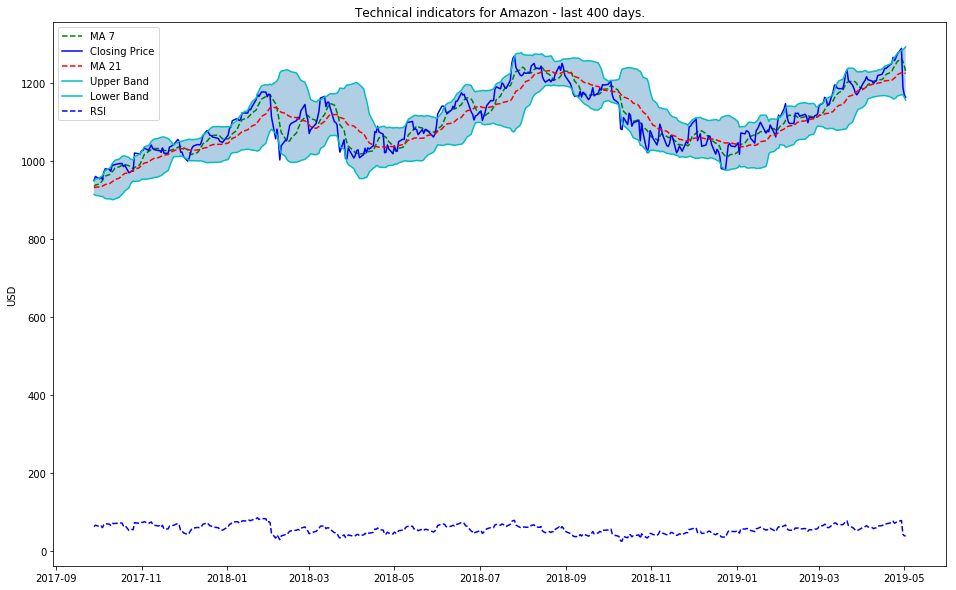

In [43]:
plot_technical_indicators(dataset, 400)

In [44]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['Close']
    X = data.iloc[:, 1:]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [45]:
(X_train, y_train), (X_test, y_test) = get_feature_importance_data(dataset_TI)

In [46]:
import xgboost as xgb

regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)


In [47]:
xgbModel = regressor.fit(X_train,y_train,eval_set = [(X_train, y_train), (X_test, y_test)], \
                         verbose=False)

In [48]:
eval_result = regressor.evals_result()

In [49]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

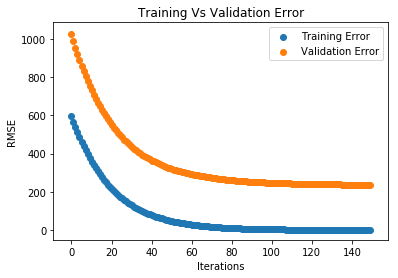

In [50]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

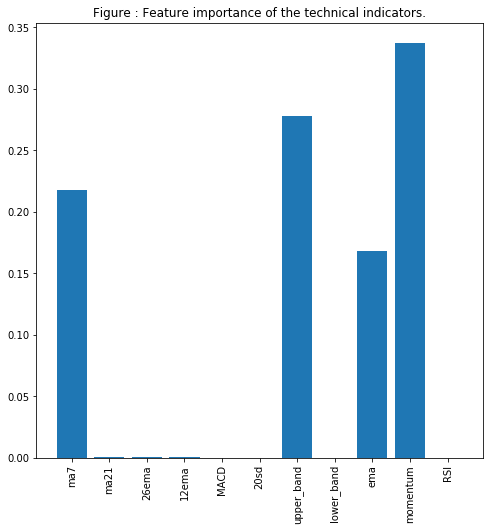

In [51]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test.columns)
plt.title('Figure : Feature importance of the technical indicators.')
plt.show()